# Gender Classifier

### Load Data

In [42]:
%store -r cnn_model

dataset = cnn_model['dataset']

abstracts_padded = cnn_model['abstracts_padded']
label_map, ys = cnn_model['label_map'], cnn_model['ys']
labels = [i for gender, i in label_map.items()]
num_classes = cnn_model['num_classes']

embeddings = cnn_model['embeddings']
word_dim = cnn_model['word_dim']
word2idx, idx2word = cnn_model['word2idx'], cnn_model['idx2word']
maxlen = cnn_model['maxlen']
vocab_size = cnn_model['vocab_size']
num_train = cnn_model['num_train']

### Train - Validation Split

In [43]:
from sklearn.cross_validation import KFold

fold = KFold(len(abstracts_padded), n_folds=5, shuffle=True)
p = iter(fold)

train_idxs, val_idxs = next(p)

X_train, ys_train = abstracts_padded[train_idxs], ys[train_idxs]
X_val, ys_val = abstracts_padded[val_idxs], ys[val_idxs]

num_train, num_val = len(X_train), len(X_val)

### Hyperparameters

In [57]:
nb_filter = 10
filter_length = 2
hidden_dims = 32
nb_epoch = 35

### Define Model

In [58]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=word_dim, weights=[embeddings], input_length=maxlen,
                   trainable=False))
model.add(Dropout(0.25))

model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        activation='relu'))
model.add(MaxPooling1D(pool_length=maxlen-1)) # non-maximum suppression

model.add(Flatten())
model.add(Dense(hidden_dims))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.layers[3].input_shape # ensure non-maximum suppression

(None, 468, 10)

### Random Balanced Minibatch Generator

In [59]:
def labelidx_generator(ys):
    """Generate a dict of labels to their indices"""

    for label in labels:
        idxs = np.argwhere(ys == label).flatten()
        yield (label, idxs)

def batch_generator(ys, batch_size, balanced=True):
    """Yield successive batches for training
    
    This generator is not meant to be exhausted, but rather called by next().
    
    Each batch has batch_size/num_classes number of examples from each class
    
    """
    assert not batch_size % num_classes
    
    labels_idxs = dict(labelidx_generator(ys))
    
    while True:
        idxs_lists = [np.random.choice(label_idxs, size=batch_size/num_classes) for label, label_idxs in labels_idxs.items()]
        idxs = [idx for idxs_list in idxs_lists for idx in idxs_list] # flatten list
        
        yield idxs

### Minibatch Training

In [60]:
batch_size = 50

example = batch_generator(ys_train, batch_size)

In [62]:
for i in range(100):
    batch = next(example)
    
    X = X_train[batch]
    ys = np.zeros([batch_size, num_classes])
    ys[np.arange(batch_size), ys_train[batch]] = 1

    print model.train_on_batch(X, ys)
    
    if not i % 10:
        predictions = model.predict(X_val)

        ysval_block = np.zeros([num_val, num_classes])
        ysval_block[np.arange(num_val), ys_val] = 1

        print 'Validation accuracy', np.mean(predictions.argmax(axis=1) == ys_val)

[array(0.4051237106323242, dtype=float32)]
Validation accuracy 0.95
[array(0.438852995634079, dtype=float32)]
[array(0.43335121870040894, dtype=float32)]
[array(0.40232330560684204, dtype=float32)]
[array(0.39063912630081177, dtype=float32)]
[array(0.41058599948883057, dtype=float32)]
[array(0.4017609655857086, dtype=float32)]
[array(0.3808741867542267, dtype=float32)]
[array(0.37839969992637634, dtype=float32)]
[array(0.3931059241294861, dtype=float32)]
[array(0.3334627151489258, dtype=float32)]
Validation accuracy 0.85
[array(0.34864750504493713, dtype=float32)]
[array(0.38565483689308167, dtype=float32)]
[array(0.37495163083076477, dtype=float32)]
[array(0.3774726390838623, dtype=float32)]
[array(0.37716686725616455, dtype=float32)]
[array(0.33516642451286316, dtype=float32)]
[array(0.3275122046470642, dtype=float32)]
[array(0.35422855615615845, dtype=float32)]
[array(0.2770668566226959, dtype=float32)]
[array(0.3274974822998047, dtype=float32)]
Validation accuracy 0.85
[array(0.340

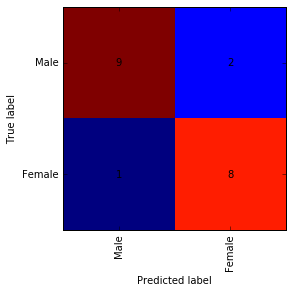

In [63]:
predictions = model.predict(X_val)

ysval_block = np.zeros([num_val, num_classes])
ysval_block[np.arange(num_val), ys_val] = 1

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ys_val, predictions.argmax(axis=1))

from support import plot_confusion_matrix

plot_confusion_matrix(cm)

### Examine Bigrams Which Filters Fire on

In [64]:
dataset.abstract.iloc[3]

'High-grade prostatic intraepithelial neoplasia (HGPIN) is generally regarded as a premalignant lesion that progresses toward prostate cancer. In light of the significant sequelae of prostate cancer treatment, prevention is desirable, and men with HGPIN would be suitable, high-risk subjects. There is in vitro, in vivo, epidemiologic, and human experimental evidence that selenium supplementation may protect against prostate cancer. This article introduces the rationale for, and progress to date, of a double-blind, randomized, placebo-controlled trial of selenium supplementation (200 mug/d in the form of selenomethionine), to prevent the development of prostate cancer among men with HGPIN. The trial, Southwest Oncology Group Protocol 9917, funded by a National Cancer Institute program supporting pivotal prevention trials has registered 537 patients and has randomized >380 to date. Subject accrual is expected to be completed by the fall of 2006, with trial completion in 2009.'

In [65]:
filters = model.layers[2].W.eval()
filters = np.squeeze(filters)
filters = [filter.T for filter in filters]

abstract = abstracts_padded[3]

def activation_generator(filter):
    for w1, w2 in zip(abstract, abstract[1:]):
        yield np.sum(embeddings[[w1, w2]] * filter), (w1, w2)
        
def activations_generator(filters):
    for filter in filters:
        yield list(activation_generator(filter))
        
activations = list(activations_generator(filters))

for activation in activations:
    for score, (w1, w2) in sorted(activation, reverse=True)[:10]:
        print score, idx2word[w1], idx2word[w2]
        
    print

0.798720959281 , of
0.774952054591 trial of
0.73860536013 fall of
0.702400612893 sequelae of
0.64464216135 light of
0.626040300484 form of
0.587058958733 development of
0.470331808933 mug/d in
0.451012829234 patients and
0.447234792295 380 to

0.948453019145 High-grade prostatic
0.913312044433 against prostate
0.767319063236 toward prostate
0.740793297183 of prostate
0.740793297183 of prostate
0.430028549477 with HGPIN
0.430028549477 with HGPIN
0.424948660743 prostatic intraepithelial
0.406655386123 prostate cancer
0.406655386123 prostate cancer

0.739442128667 prostate cancer
0.739442128667 prostate cancer
0.739442128667 prostate cancer
0.739442128667 prostate cancer
0.505323125421 prostatic intraepithelial
0.414727436614 HGPIN .
0.397632603225 HGPIN would
0.352371829526 HGPIN )
0.345550896384 cancer .
0.345550896384 cancer .

0.956685807885 placebo-controlled trial
0.909004443632 a double-blind
0.705730790525 The trial
0.643539490309 , placebo-controlled
0.591753288058 , randomized
0